In [ ]:
!apt-get update
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

mpl.rcParams['axes.unicode_minus'] = False

plt.rc('font', family = 'NanumBarunGothic')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/iso/data.zip

Archive:  /content/drive/My Drive/Colab Notebooks/iso/data.zip
   creating: 1. 인증현황데이터/
  inflating: 1. 인증현황데이터/(onycom)규모별_인증현황데이터.xls  
  inflating: 1. 인증현황데이터/(onycom)업종별_인증현황데이터.xls  
  inflating: 1. 인증현황데이터/(onycom)지역별_인증현황데이터.xls  
   creating: 2. 인증부적합 발행현황/
  inflating: 2. 인증부적합 발행현황/(onycom)통합_인증_적합부적합발행현황_12092021.csv  
   creating: 3. 인증별 부적합 세부내용/
  inflating: 3. 인증별 부적합 세부내용/(onycom)IATF16949_인증부적합현황_12092021.csv  
  inflating: 3. 인증별 부적합 세부내용/(onycom)TS16949_인증부적합현황_12092021.csv  


In [ ]:
import pandas as pd
IATF = pd.read_csv('/content/3. 인증별 부적합 세부내용/(onycom)IATF16949_인증부적합현황_12092021.csv', encoding = 'cp949')
IATF.head()

,심사일자,심사종류,중부적합건수,경부적합건수,심사원수,기업명,심사지역,국가,대륙,4.1 중부적합,4.1 경부적합,4.2 중부적합,4.2 경부적합,4.3 중부적합,4.3 경부적합,4.3.1 중부적합,4.3.1 경부적합,4.3.2 중부적합,4.3.2 경부적합,4.4.1 중부적합,4.4.1 경부적합,4.4.1.1 중부적합,4.4.1.1 경부적합,4.4.1.2 중부적합,4.4.1.2 경부적합,4.4.2 중부적합,4.4.2 경부적합,5.1.1 중부적합,5.1.1 경부적합,5.1.1.1 중부적합,5.1.1.1 경부적합,5.1.1.2 중부적합,5.1.1.2 경부적합,5.1.1.3 중부적합,5.1.1.3 경부적합,5.1.2 중부적합,5.1.2 경부적합,5.2.1 중부적합,5.2.1 경부적합,5.2.2 중부적합,...,9.2.2.2 중부적합,9.2.2.2 경부적합,9.2.2.3 중부적합,9.2.2.3 경부적합,9.2.2.4 중부적합,9.2.2.4 경부적합,9.3.1 중부적합,9.3.1 경부적합,9.3.1.1 중부적합,9.3.1.1 경부적합,9.3.2 중부적합,9.3.2 경부적합,9.3.2.1 중부적합,9.3.2.1 경부적합,9.3.3 중부적합,9.3.3 경부적합,9.3.3.1 중부적합,9.3.3.1 경부적합,10.1 중부적합,10.1 경부적합,10.2.1 중부적합,10.2.1 경부적합,10.2.2 중부적합,10.2.2 경부적합,10.2.3 중부적합,10.2.3 경부적합,10.2.4 중부적합,10.2.4 경부적합,10.2.5 중부적합,10.2.5 경부적합,10.2.6 중부적합,10.2.6 경부적합,10.3 중부적합,10.3 경부적합,10.3.1 중부적합,10.3.1 경부적합,A.1 중부적합,A.1 경부적합,A.2 중부적합,A.2 경부적합
0,2017-02,최초,0,8,3.0,S******,Cheongju-si,Republic of Korea,Asia Pacific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-03,최초,0,6,1.0,H******,Cheonan-si,Republic of Korea,Asia Pacific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-04,규격전환심사,0,6,2.0,D******,Daejeon,Republic of Korea,Asia Pacific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-06,규격전환심사,0,3,1.0,S******,Gunsan,Republic of Korea,Asia Pacific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-07,규격전환심사,0,5,2.0,D******,Daegu,Republic of Korea,Asia Pacific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 전처리

In [ ]:
IATF_KR = IATF[IATF['국가'] == 'Republic of Korea']
df = IATF_KR[['심사일자', '심사종류', '경부적합건수', '심사원수', '심사지역']]
df

,심사일자,심사종류,경부적합건수,심사원수,심사지역
0,2017-02,최초,8,3.0,Cheongju-si
1,2017-03,최초,6,1.0,Cheonan-si
2,2017-04,규격전환심사,6,2.0,Daejeon
3,2017-06,규격전환심사,3,1.0,Gunsan
4,2017-07,규격전환심사,5,2.0,Daegu
...,...,...,...,...,...
3218,2021-11,사후심사,2,2.0,Asan-si
3219,2021-11,사후심사,3,2.0,Gijang-gun
3220,2021-11,사후심사,2,1.0,Chilgok-gun
3221,2021-11,사후심사,4,1.0,Changwon-si


In [ ]:
feature_LE = ['심사종류', '심사지역']

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

for i in feature_LE:
    df[i] = LE.fit_transform(df[i])

In [ ]:
df

,심사일자,심사종류,경부적합건수,심사원수,심사지역
0,2017-02,4,8,3.0,18
1,2017-03,4,6,1.0,16
2,2017-04,1,6,2.0,24
3,2017-06,1,3,1.0,46
4,2017-07,1,5,2.0,23
...,...,...,...,...,...
3218,2021-11,2,2,2.0,5
3219,2021-11,2,3,2.0,35
3220,2021-11,2,2,1.0,20
3221,2021-11,2,4,1.0,14


## EDA

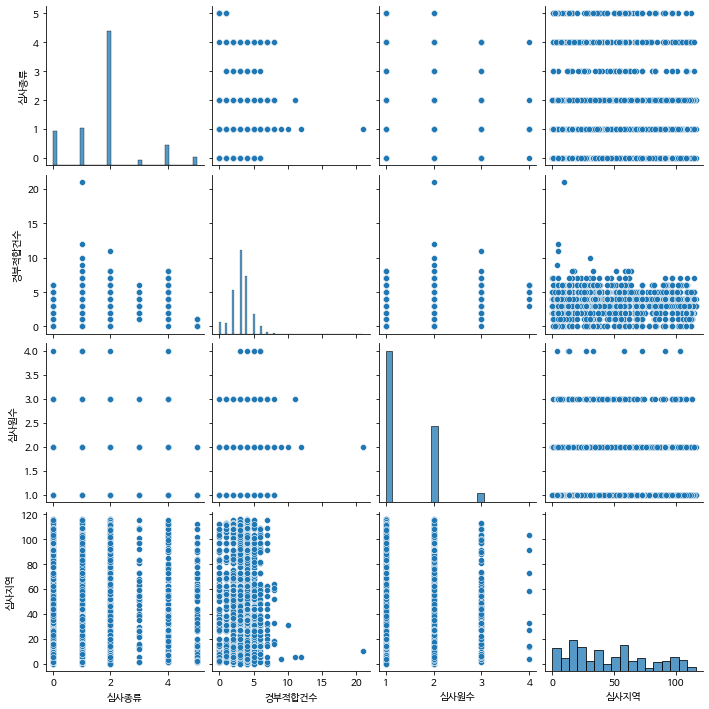

In [ ]:
import seaborn as sns
sns.pairplot(df)

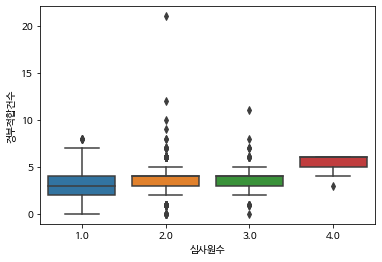

In [ ]:
import seaborn as sns

sns.boxplot(x='심사원수', y='경부적합건수', data = IATF_KR)

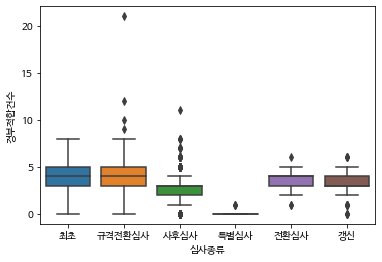

In [ ]:
import seaborn as sns

sns.boxplot(x='심사종류', y='경부적합건수', data = IATF_KR)

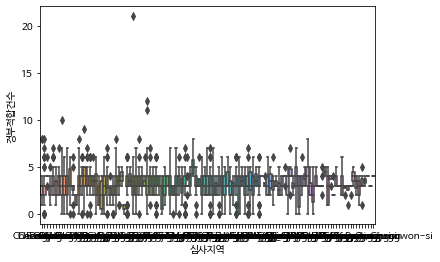

In [ ]:
import seaborn as sns

sns.boxplot(x='심사지역', y='경부적합건수', data = IATF_KR)

## 심사종류, 심사원수, 심사지역에 따른 경부적합건수 예측

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['심사일자', '경부적합건수'])
y = df['경부적합건수']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (2203, 3) (2203,)
Test Data :  (945, 3) (945,)


In [ ]:
from xgboost import XGBRegressor

XGB = XGBRegressor(booster = 'gblinear',
                   n_estimators = 100,
                   learning_rate = 0.4,
                   reg_lambda = 2.0,
                   n_jobs = -1,
                   random_state = 2045,
                   objective='reg:squarederror')

XGB.fit(X_train, y_train)

XGBRegressor(booster='gblinear', learning_rate=0.4, n_jobs=-1,
             objective='reg:squarederror', random_state=2045, reg_lambda=2.0)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, XGB.predict(X_test))
np.sqrt(mse)

1.3356996739442872

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, XGB.predict(X_test))
norm=(abs(y_test).sum())/len(y_test)
nmae=mae/norm
print('nmae:', nmae)

nmae: 0.3165997254760414


In [ ]:
X_test

,심사종류,심사원수,심사지역
3088,0,2.0,91
3119,2,1.0,59
2559,0,2.0,58
1757,2,1.0,38
2178,3,1.0,108
...,...,...,...
2223,2,1.0,52
2882,2,1.0,31
1943,2,1.0,26
2700,0,2.0,23


In [ ]:
X_test['predict'] = XGB.predict(X_test)
X_test

,심사종류,심사원수,심사지역,predict
3088,0,2.0,91,3.357343
3119,2,1.0,59,3.088580
2559,0,2.0,58,3.360671
1757,2,1.0,38,3.090697
2178,3,1.0,108,2.986263
...,...,...,...,...
2223,2,1.0,52,3.089286
2882,2,1.0,31,3.091403
1943,2,1.0,26,3.091908
2700,0,2.0,23,3.364201


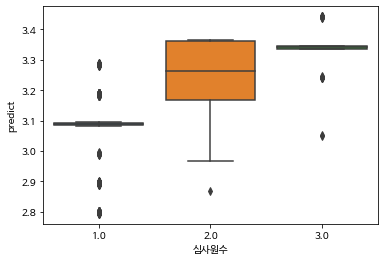

In [ ]:
import seaborn as sns

sns.boxplot(x='심사원수', y='predict', data = X_test)

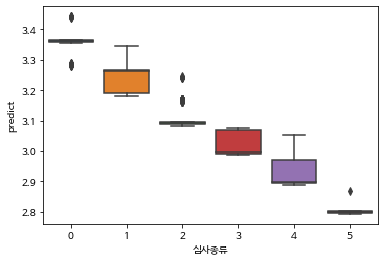

In [ ]:
import seaborn as sns

sns.boxplot(x='심사종류', y='predict', data = X_test)

## 부적합 종류 통계 

In [ ]:
IATF = IATF.fillna(0)

In [ ]:
kind = IATF.drop(columns = ['심사일자', '심사종류', '기업명', '심사지역', '국가', '대륙'])
kind

### 심사원수에 따라 

In [ ]:
kind0 = pd.DataFrame(kind[kind['심사원수'] == 1].sum())
kind0[2] = pd.DataFrame(kind[kind['심사원수'] == 2].sum())
kind0[3] = pd.DataFrame(kind[kind['심사원수'] == 3].sum())
kind0[4] = pd.DataFrame(kind[kind['심사원수'] == 4].sum())
kind0.rename(columns = {0:1}, inplace = True)
kind0

In [ ]:
kind0['합계'] = kind0.sum(axis=1)

In [ ]:
kind0[kind0['합계'] >= 200][3:]

,1,2,3,4,합계
6.1.2.1 경부적합,136.0,81.0,16.0,2.0,235.0
6.1.2.3 경부적합,465.0,184.0,8.0,1.0,658.0
7.1.5.1.1 경부적합,270.0,152.0,26.0,5.0,453.0
7.1.5.2.1 경부적합,245.0,177.0,19.0,1.0,442.0
7.2.2 경부적합,155.0,64.0,8.0,2.0,229.0
8.3.3.2 경부적합,159.0,112.0,13.0,0.0,284.0
8.3.3.3 경부적합,180.0,134.0,28.0,7.0,349.0
8.3.5.2 경부적합,146.0,120.0,17.0,0.0,283.0
8.4.2.3 경부적합,115.0,83.0,5.0,1.0,204.0
8.4.2.4 경부적합,153.0,134.0,19.0,2.0,308.0


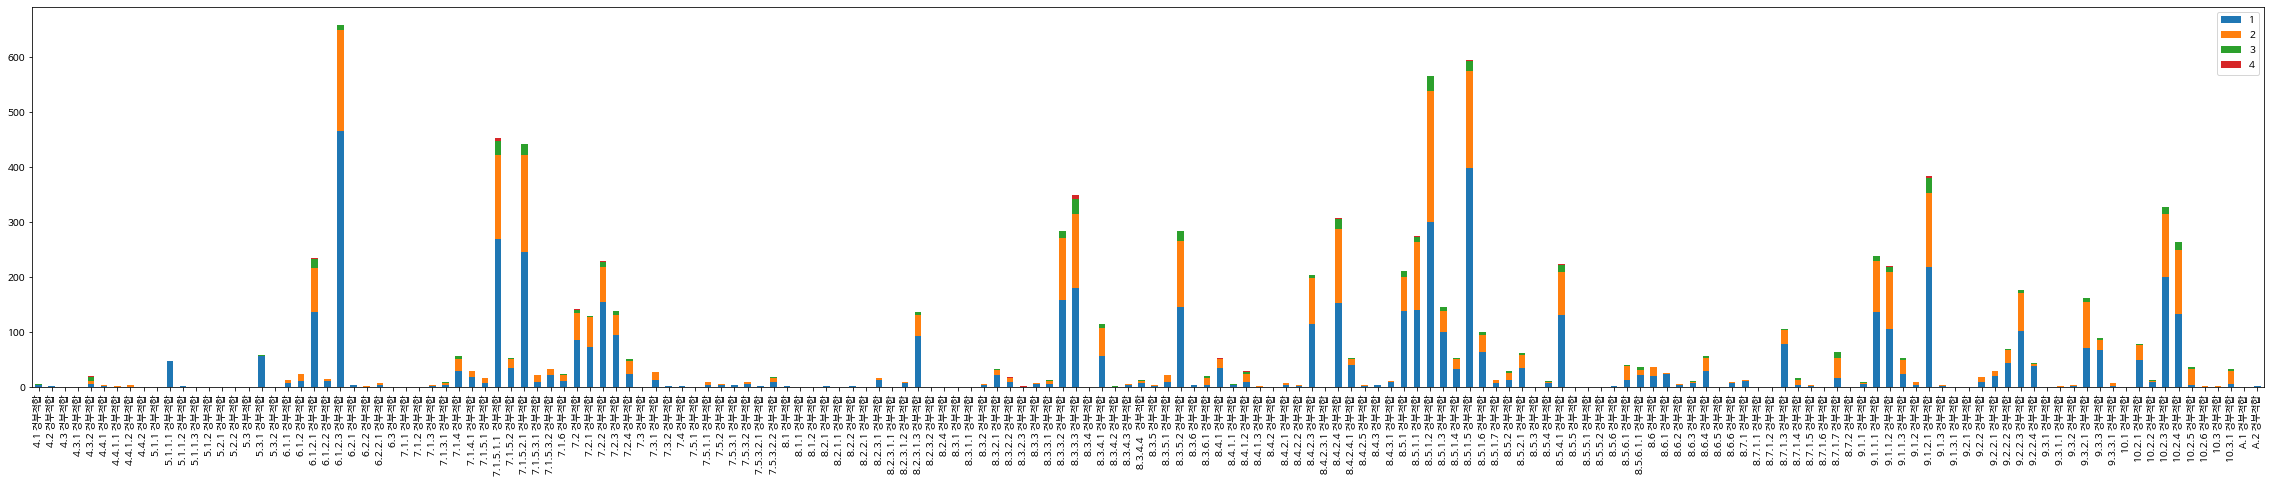

In [ ]:
kind0[kind0.index.str.contains('경부적합')][1:].plot.bar(stacked=True, figsize = (40,7))

### 심사종류에 따라

In [ ]:
IATF['심사종류'].unique()

array(['최초', '규격전환심사', '사후심사', '특별심사', '전환심사', '갱신'], dtype=object)

In [ ]:
kind1 = pd.DataFrame(IATF[IATF['심사종류'] == '최초'].sum())
kind1['규격전환심사'] = pd.DataFrame(IATF[IATF['심사종류'] == '규격전환심사'].sum())
kind1['사후심사'] = pd.DataFrame(IATF[IATF['심사종류'] == '사후심사'].sum())
kind1['특별심사'] = pd.DataFrame(IATF[IATF['심사종류'] == '특별심사'].sum())
kind1['전환심사'] = pd.DataFrame(IATF[IATF['심사종류'] == '전환심사'].sum())
kind1['갱신'] = pd.DataFrame(IATF[IATF['심사종류'] == '갱신'].sum())
kind1.rename(columns = {0:'최초'}, inplace = True)
kind1[9:]

,최초,규격전환심사,사후심사,특별심사,전환심사,갱신
4.1 중부적합,0,0,0,0,0,0
4.1 경부적합,0,2,2,0,2,0
4.2 중부적합,0,0,0,0,0,0
4.2 경부적합,0,2,0,0,0,0
4.3 중부적합,0,0,0,0,0,0
...,...,...,...,...,...,...
10.3.1 경부적합,0,2,21,0,0,10
A.1 중부적합,0,0,0,0,0,0
A.1 경부적합,0,0,0,0,0,0
A.2 중부적합,0,0,0,0,0,0


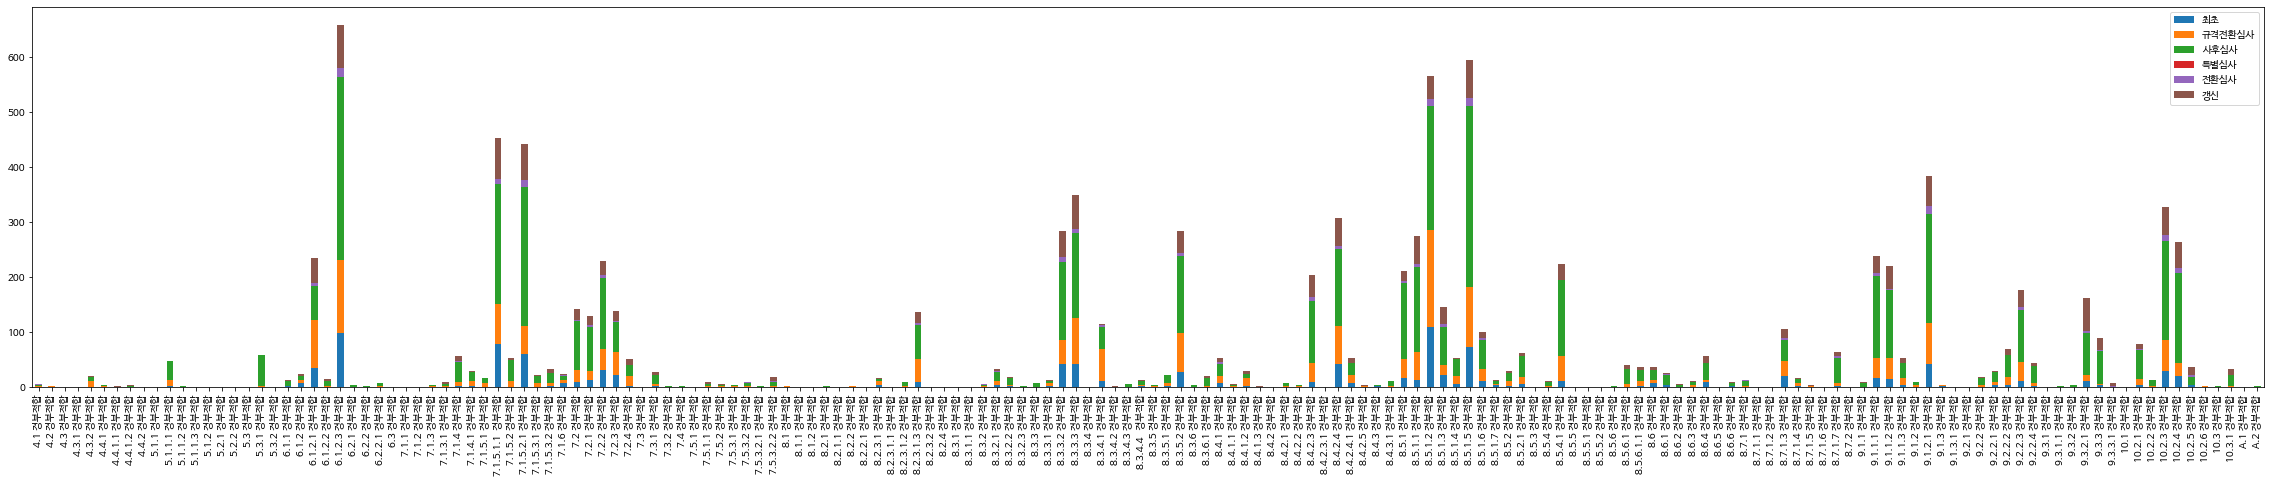

In [ ]:
kind1[kind1.index.str.contains('경부적합')][1:].plot.bar(stacked=True, figsize = (40,7))

### 최초심사일 경우 심사원수에 따라 

In [ ]:
first = IATF[IATF['심사종류'] == '최초'].drop(columns = ['심사일자', '심사종류', '기업명', '심사지역', '국가', '대륙'])
first

,중부적합건수,경부적합건수,심사원수,4.1 중부적합,4.1 경부적합,4.2 중부적합,4.2 경부적합,4.3 중부적합,4.3 경부적합,4.3.1 중부적합,4.3.1 경부적합,4.3.2 중부적합,4.3.2 경부적합,4.4.1 중부적합,4.4.1 경부적합,4.4.1.1 중부적합,4.4.1.1 경부적합,4.4.1.2 중부적합,4.4.1.2 경부적합,4.4.2 중부적합,4.4.2 경부적합,5.1.1 중부적합,5.1.1 경부적합,5.1.1.1 중부적합,5.1.1.1 경부적합,5.1.1.2 중부적합,5.1.1.2 경부적합,5.1.1.3 중부적합,5.1.1.3 경부적합,5.1.2 중부적합,5.1.2 경부적합,5.2.1 중부적합,5.2.1 경부적합,5.2.2 중부적합,5.2.2 경부적합,5.3 중부적합,5.3 경부적합,5.3.1 중부적합,5.3.1 경부적합,5.3.2 중부적합,...,9.2.2.2 중부적합,9.2.2.2 경부적합,9.2.2.3 중부적합,9.2.2.3 경부적합,9.2.2.4 중부적합,9.2.2.4 경부적합,9.3.1 중부적합,9.3.1 경부적합,9.3.1.1 중부적합,9.3.1.1 경부적합,9.3.2 중부적합,9.3.2 경부적합,9.3.2.1 중부적합,9.3.2.1 경부적합,9.3.3 중부적합,9.3.3 경부적합,9.3.3.1 중부적합,9.3.3.1 경부적합,10.1 중부적합,10.1 경부적합,10.2.1 중부적합,10.2.1 경부적합,10.2.2 중부적합,10.2.2 경부적합,10.2.3 중부적합,10.2.3 경부적합,10.2.4 중부적합,10.2.4 경부적합,10.2.5 중부적합,10.2.5 경부적합,10.2.6 중부적합,10.2.6 경부적합,10.3 중부적합,10.3 경부적합,10.3.1 중부적합,10.3.1 경부적합,A.1 중부적합,A.1 경부적합,A.2 중부적합,A.2 경부적합
0,0,8,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,0,4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3200,0,4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3202,0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3207,0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.

In [ ]:
kind2 = pd.DataFrame(first[first['심사원수'] == 1].sum())
kind2[2] = pd.DataFrame(first[first['심사원수'] == 2].sum())
kind2[3] = pd.DataFrame(first[first['심사원수'] == 3].sum())
kind2[4] = pd.DataFrame(first[first['심사원수'] == 4].sum())
kind2.rename(columns = {0:1}, inplace = True)
kind2

,1,2,3,4
중부적합건수,14.0,0.0,0.0,0.0
경부적합건수,668.0,417.0,41.0,6.0
심사원수,175.0,204.0,24.0,4.0
4.1 중부적합,0.0,0.0,0.0,0.0
4.1 경부적합,0.0,0.0,0.0,0.0
...,...,...,...,...
10.3.1 경부적합,0.0,0.0,0.0,0.0
A.1 중부적합,0.0,0.0,0.0,0.0
A.1 경부적합,0.0,0.0,0.0,0.0
A.2 중부적합,0.0,0.0,0.0,0.0


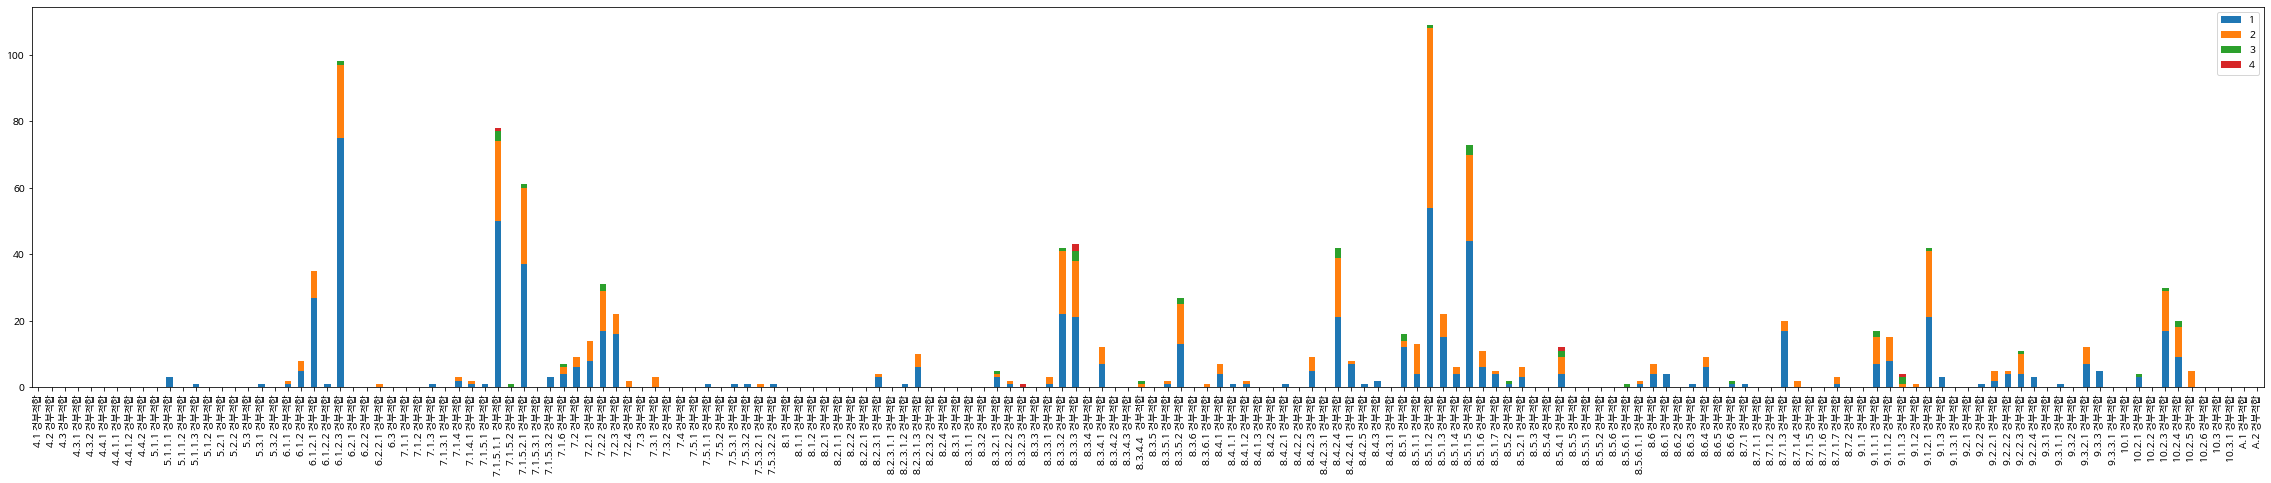

In [ ]:
kind2[kind2.index.str.contains('경부적합')][1:].plot.bar(stacked=True, figsize = (40,7))

## 기업규모와 심사원수 매칭하기

In [ ]:
size = pd.read_excel('/content/1. 인증현황데이터/(onycom)규모별_인증현황데이터.xls')

In [ ]:
size_p = pd.DataFrame(size['기업규모 (규모)'].value_counts()/size['기업규모 (규모)'].value_counts().sum())
size_p = size_p.reindex(index = ['1~ 9인', '10~ 29인', '30~ 49인', '50~ 99인', '100~ 199인',
                        '200~ 299인', '300~ 499인', '500~ 699인', '700~ 999인', '1,000인 이상'])
size_p

,기업규모 (규모)
1~ 9인,0.232236
10~ 29인,0.419984
30~ 49인,0.107688
50~ 99인,0.120693
100~ 199인,0.062318
200~ 299인,0.023921
300~ 499인,0.020272
500~ 699인,0.002560
700~ 999인,0.003384
"1,000인 이상",0.006944


In [ ]:
size_p.sum() / 4

기업규모 (규모)    8496.75
dtype: float64

* 심사원수 1 : 1  ~ 29인
* 심사원수 2 : 30 ~ 299인
* 심사원수 3 : 300 ~ 999인
* 심사원수 4 : 1000인 이상

In [ ]:
IATF['심사원수'].value_counts()/IATF['심사원수'].value_counts().sum()

1.0    0.639156
2.0    0.318647
3.0    0.039404
4.0    0.002792
Name: 심사원수, dtype: float64

## 추천

In [ ]:
a = IATF[(IATF['심사원수'] == 1) & (IATF['심사종류'] == '최초')]
a[a.columns[9:]].sum().nlargest(10)

6.1.2.3 경부적합       75.0
8.5.1.2 경부적합       54.0
7.1.5.1.1  경부적합    50.0
8.5.1.5 경부적합       44.0
7.1.5.2.1 경부적합     37.0
6.1.2.1 경부적합       27.0
8.3.3.2 경부적합       22.0
8.3.3.3 경부적합       21.0
8.4.2.4 경부적합       21.0
9.1.2.1 경부적합       21.0
dtype: float64

In [ ]:
b = IATF[(IATF['심사원수'] == 1) & (IATF['심사종류'] == '갱신')]
b[b.columns[9:]].sum().nlargest(10)

6.1.2.1 경부적합       15.0
8.5.1.5 경부적합       14.0
6.1.2.3 경부적합       12.0
7.1.5.1.1  경부적합    12.0
9.1.2.1 경부적합       11.0
8.5.1.3 경부적합       10.0
10.2.3 경부적합        10.0
8.3.3.3 경부적합        9.0
8.4.2.4 경부적합        8.0
8.3.3.2 경부적합        7.0
dtype: float64

In [ ]:
def input_output(type, size):
    input = IATF[(IATF['심사종류'] == type) & IATF['심사원수'] == size]
    process = input[input.columns[9:]].sum().nlargest(10)
    output = pd.DataFrame(output).index
    return output